# 3.6 半监督学习实战

sklearn的semi_supervised模块提供了两种标签传播模型：LabelPropagation和LabelSpreading。两者都是通过在输入数据集中的所有样本上构建相似图来进行工作，只是对图形的相似性矩阵以及对标签分布的夹持效应（clamping effect）方面不太一样，两者的具体原理不在此展开讨论，请读者参考其他资料。

下面将以手写数字识别问题为例，使用LabelSpreading模型来完成仅有少量样本有标签的手写数字数据集的分类任务。

首先载入数据：


In [1]:
import numpy as np
from sklearn import datasets
digits = datasets.load_digits()
total = len(digits.data)
indices = np.arange(total)
np.random.RandomState(2).shuffle(indices)  #indices变为乱序序列
X = digits.data[indices]  #打乱顺序后的数据样本
y = digits.target[indices]  #打乱顺序后的数据标签

接下来构造用于半监督学习的数据集：

In [2]:
labeled_points = 40  # 设置有标签数据为前40个样本
y_train = np.copy(y)
y_train[labeled_points:] = -1  # 将训练集中40以后的数据标签设为“-1”(去标签)

下面就可以定义模型、进行训练，并查看分类结果：

In [3]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
lp_model = LabelSpreading(gamma=0.25)  # 实例化LabelSpreading模型,gamma是超参数
lp_model.fit(X, y_train)  # 训练模型
pred_labels = lp_model.transduction_[labeled_points:]  # 获取预测结果
true_labels = y[labeled_points:]  # 获取真实标签
# 查看模型分类结果报告
print(
    "Label Spreading model: %d labeled & %d unlabeled points (%d total)"
    % (labeled_points, total - labeled_points, total)
)
print(classification_report(true_labels, pred_labels))  # 打印性能指标
print(confusion_matrix(true_labels, pred_labels))  # 打印混淆矩阵

Label Spreading model: 40 labeled & 1757 unlabeled points (1797 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       0.81      0.97      0.88       177
           2       0.98      0.93      0.95       175
           3       0.98      0.93      0.95       182
           4       0.97      0.98      0.98       173
           5       0.90      0.96      0.93       176
           6       0.99      1.00      1.00       173
           7       0.98      0.96      0.97       176
           8       0.92      0.80      0.86       173
           9       0.93      0.89      0.91       176

    accuracy                           0.94      1757
   macro avg       0.95      0.94      0.94      1757
weighted avg       0.95      0.94      0.94      1757

[[176   0   0   0   0   0   0   0   0   0]
 [  0 172   0   0   3   1   0   0   0   1]
 [  0  10 163   1   0   0   0   0   1   0]
 [  0   0   0 169   0   2   0   1   5   5

<IPython.core.display.Javascript object>


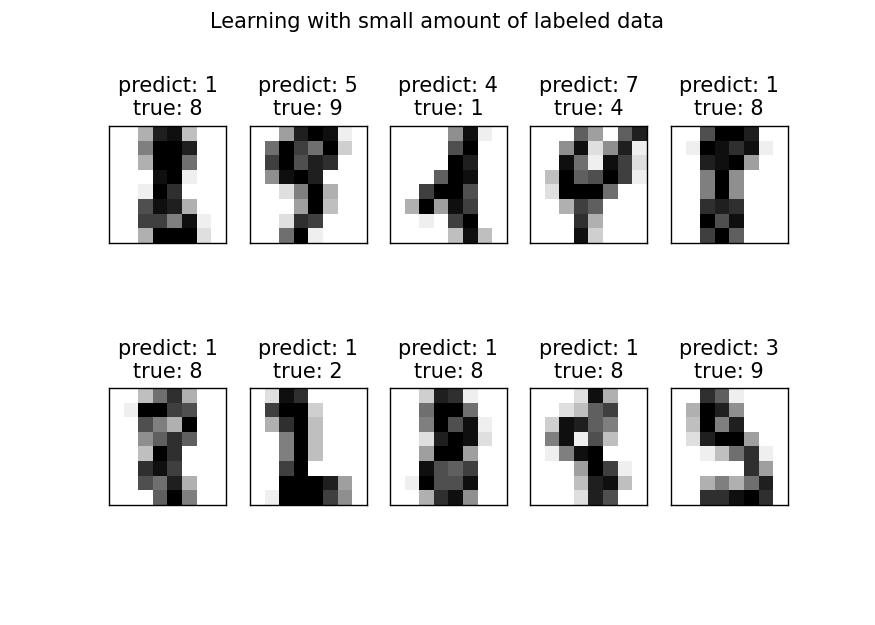

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
error_index = np.where(pred_labels-true_labels != 0)[0]  # 得到所有错误结果的索引
f = plt.figure(figsize=(7, 5))  # 画图
f.suptitle("Learning with small amount of labeled data")
for i, index in enumerate(error_index[:10]):
    image = X[index + labeled_points].reshape(8,8)
    sub = f.add_subplot(2, 5, i + 1)  # 通过2行5列的方式展示每个子图
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])  # 不显示坐标轴
    plt.yticks([])
    sub.set_title(  # 通过副标题显示预测标签与真实标签
        "predict: %i\ntrue: %i" % (pred_labels[index], true_labels[index])
    )

由于半监督学习考虑了全部样本的分布，因此性能上优于比只训练少量有标签样本的逻辑回归算法。下面还是以上例中的40个带标签样本来训练一个一般的逻辑回归分类器，对剩余标签进行分类，可对比分类效果。代码如下：

In [5]:
from sklearn import ensemble 
clf = ensemble.ExtraTreesClassifier()  #实例化极限树分类模型
clf = clf.fit(X[:labeled_points], y_train[:labeled_points])  #训练模型
pred = clf.predict(X[labeled_points:])  #预测
print(classification_report(y[labeled_points:], pred))  #打印性能指标
print(confusion_matrix(y[labeled_points:], pred))  # 打印混淆矩阵

              precision    recall  f1-score   support

           0       0.97      0.85      0.90       176
           1       0.54      0.84      0.66       177
           2       0.89      0.32      0.47       175
           3       0.91      0.38      0.54       182
           4       0.48      0.99      0.64       173
           5       0.69      0.89      0.78       176
           6       0.74      0.98      0.84       173
           7       0.84      0.78      0.81       176
           8       0.94      0.09      0.17       173
           9       0.71      0.78      0.74       176

    accuracy                           0.69      1757
   macro avg       0.77      0.69      0.66      1757
weighted avg       0.77      0.69      0.66      1757

[[149   0   0   0  12   0   6   0   0   9]
 [  0 149   0   0  23   1   0   1   0   3]
 [  0  84  56   1  19   0  12   3   0   0]
 [  1  16   7  70   2  30   8  17   0  31]
 [  0   0   0   0 172   0   0   1   0   0]
 [  0   1   0   0   5 157 